In [1]:
# Standard Imports
import os
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 
import matplotlib.image as implt 

# For Network
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import optimizers
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [2]:
BATCH_SIZE = 64
EPOCHS = 20

TRAIN_PATH = '/kaggle/input/labeled-chest-xray-images/chest_xray/train'
TEST_PATH = '/kaggle/input/labeled-chest-xray-images/chest_xray/test'

TRAIN_NORMAL = os.listdir(TRAIN_PATH + '/NORMAL')
TRAIN_PNEUMONIA = os.listdir(TRAIN_PATH + '/PNEUMONIA')

TEST_NORMAL = os.listdir(TEST_PATH + '/NORMAL')
TEST_PNEUMONIA = os.listdir(TEST_PATH + '/PNEUMONIA')


TARGET_SIZE = (300, 300)
GREY = (3,)
INPUT_SIZE = TARGET_SIZE + GREY

CLASSES = ['Normal','Pneumonia']

In [4]:
train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale=1./255,
                                   rotation_range=5, 
                                   width_shift_range=0.1, 
                                   height_shift_range=0.1, 
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   samplewise_center=True,
                                   samplewise_std_normalization=True) 
                                   
train_generator = train_datagen.flow_from_directory(directory=TRAIN_PATH, batch_size=BATCH_SIZE, class_mode='categorical', target_size=TARGET_SIZE, subset='training')

validation_generator = train_datagen.flow_from_directory(directory=TRAIN_PATH, batch_size=BATCH_SIZE, class_mode='categorical', target_size=TARGET_SIZE, subset='validation')

image_train, label_train = train_generator.next()




# Test 
test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_directory(directory=TEST_PATH, batch_size = BATCH_SIZE, class_mode='categorical', target_size=TARGET_SIZE, shuffle=True)

image_test, label_test = test_generator.next()

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


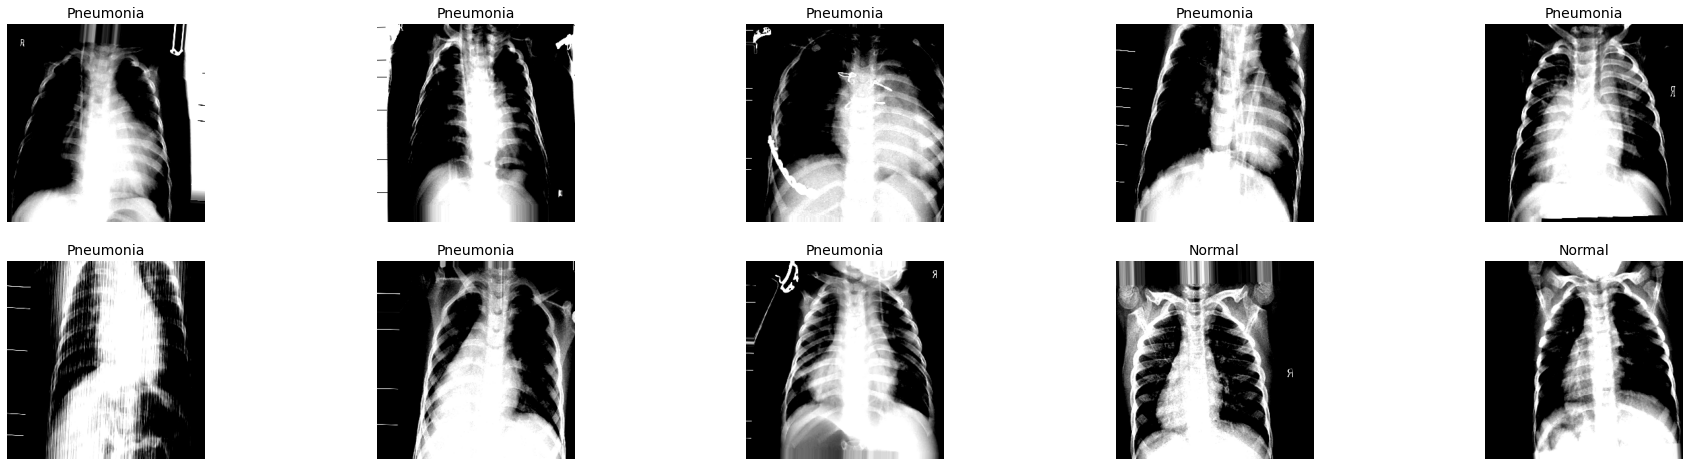

In [5]:
def show_tarin(batch_size, images, labels):
    
    images = images[0:batch_size,:,:,:]
    labels = labels[0:batch_size,:]
    
    image_rows = 2
    image_col = int(batch_size/image_rows)
    
    _, axs = plt.subplots(image_rows, image_col, figsize=(32,8))
    axs = axs.flatten()
    
    for i in range(batch_size):
        img = images[i,:,:,:]
        lab = labels[i,:]
        axs[i].imshow(img)
        axs[i].axis('off')
        lab = np.argmax(lab)
        axs[i].set_title(label = CLASSES[lab], fontsize=14)

    plt.show()
    
    
show_tarin(10, image_train, label_train)

In [6]:
# InceptionV3 Transfer Learning
def craete_model():
    
    # Load v3 model without the top layer
    inception_v3_model = InceptionV3(input_shape=INPUT_SIZE, weights='imagenet', include_top=False)

    # Freeze
    inception_v3_model.trainable = False
    
    # New classifier layers
    flatten = Flatten()(inception_v3_model.layers[-1].output) # Flatten v3 layers (except the last).
    fc1 = Dense(units=512, activation='relu')(flatten)
    dropout = Dropout(0.05)(fc1)
    output = Dense(2, activation='softmax')(dropout)
   
    # Define a new Model
    model = Model(inputs=inception_v3_model.input, outputs=output)
    
    # Summary
    model.summary()
    
    return model


model = craete_model()

87916544/87910968 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_____________________________

**Optimizer is Nadam with a learning rate of 0.00001.**

**CategoricalCrossentropy as the loss metric**



In [7]:
opt = optimizers.Nadam(learning_rate=0.00001)
loss = CategoricalCrossentropy()
met = 'accuracy'

model.compile(optimizer=opt, loss=loss, metrics=[met])

In [10]:
my_callbacks = [EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=5, mode='auto',restore_best_weights=False, verbose=1),

                ModelCheckpoint(filepath='inV3_model.h5', monitor='val_accuracy', save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch', verbose=1)]
              

In [11]:
history = model.fit(train_generator, 
                    epochs=EPOCHS, batch_size=BATCH_SIZE,
                    validation_data=validation_generator,
                    callbacks=[my_callbacks],
                    verbose=1)

Epoch 1/20
66/66 [==============================] - 186s 3s/step - loss: 0.5637 - accuracy: 0.8045 - val_loss: 0.2568 - val_accuracy: 0.8947

Epoch 00001: val_accuracy improved from -inf to 0.89474, saving model to inV3_model.h5
Epoch 2/20
66/66 [==============================] - 149s 2s/step - loss: 0.1701 - accuracy: 0.9318 - val_loss: 0.0970 - val_accuracy: 0.9589

Epoch 00002: val_accuracy improved from 0.89474 to 0.95885, saving model to inV3_model.h5
Epoch 3/20
66/66 [==============================] - 149s 2s/step - loss: 0.1284 - accuracy: 0.9474 - val_loss: 0.0875 - val_accuracy: 0.9684

Epoch 00003: val_accuracy improved from 0.95885 to 0.96842, saving model to inV3_model.h5
Epoch 4/20
66/66 [==============================] - 152s 2s/step - loss: 0.1321 - accuracy: 0.9482 - val_loss: 0.0950 - val_accuracy: 0.9665

Epoch 00004: val_accuracy did not improve from 0.96842
Epoch 5/20
66/66 [==============================] - 157s 2s/step - loss: 0.1027 - accuracy: 0.9606 - val_loss:

In [12]:
model.save('/kaggle/working/inV3_model.h5')
print('\n*** Model Saved ***')


*** Model Saved ***


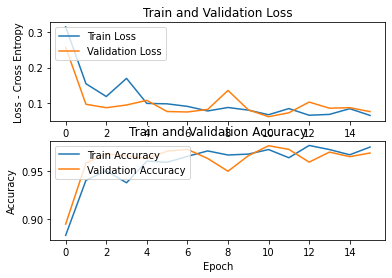

In [13]:
def graphs_learning_display(history):
    
    # Train and Test Loss
    plt.subplot(2,1,1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend(loc='upper left')
    plt.xlabel('Epoch')
    plt.ylabel('Loss - Cross Entropy')
    plt.title('Train and Validation Loss')
    
    # Train and Test Accuracy
    plt.subplot(2,1,2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend(loc='upper left')
    plt.xlabel('Epoch'),
    plt.ylabel('Accuracy')
    plt.title('Train and Validation Accuracy')
    
    plt.show()
    

graphs_learning_display(history)

In [14]:
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)


print('Test Loss: ', test_loss)
print('Test Accuracy:', '\033[0m', test_accuracy, '%\033[0m')

10/10 [==============================] - 11s 1s/step - loss: 0.4453 - accuracy: 0.8349
Test Loss:  0.44526907801628113
Test Accuracy:  0.8349359035491943 %


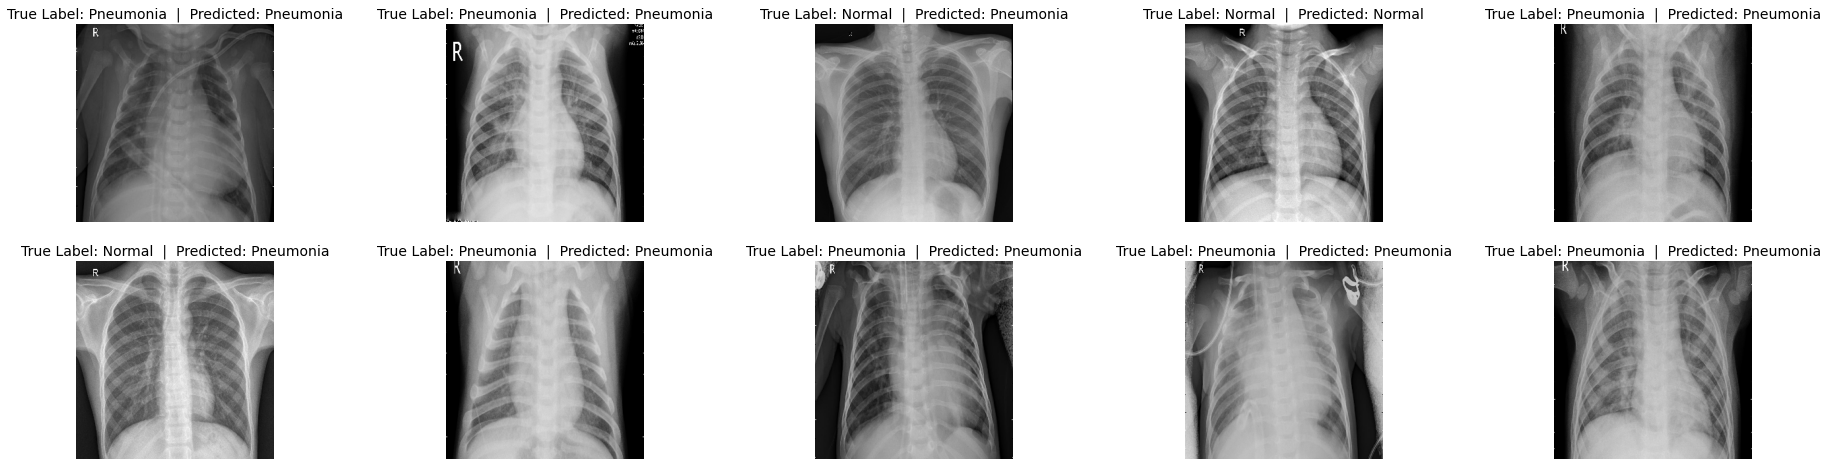

In [16]:
def show(model, batch_size, images, labels):
    
    images = images[0:batch_size,:,:,:]
    labels = labels[0:batch_size,:]
    predict = np.round(model.predict(images))
    
    image_rows = 2
    image_col = int(batch_size/image_rows)
    
    _, axs = plt.subplots(image_rows, image_col, figsize=(32,8))
    axs = axs.flatten()
    
    for i in range(batch_size):
        img = images[i,:,:,:]
        lab = labels[i,:]
        axs[i].imshow(img)
        pred = predict[i]
        axs[i].axis('off')
        lab, pred = np.argmax(lab), np.argmax(pred)
        axs[i].set_title(label = f'True Label: {CLASSES[lab]}  |  Predicted: {CLASSES[pred]}', fontsize=14)

    plt.show()
    
    
show(model, 10, image_test, label_test)

Text(0.5, 1.0, 'Confusion Matrix')

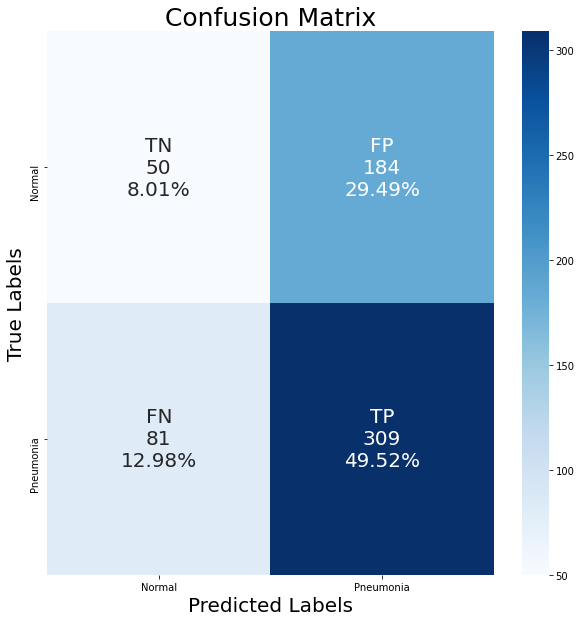

In [17]:
y_pred = model.predict(test_generator).argmax(axis=-1)

conf_mat = confusion_matrix(test_generator.classes, y_pred)


group_names = ['TN','FP','FN','TP']
group_counts = ['{0:0.0f}'.format(value) for value in conf_mat.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in conf_mat.flatten()/np.sum(conf_mat)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, xticklabels=CLASSES, yticklabels=CLASSES, ax=ax, annot=labels, fmt='', cbar=True, annot_kws={'size': 20}, cmap='Blues')
ax.set_xlabel('Predicted Labels', fontsize=20)
ax.set_ylabel('True Labels', fontsize=20)
plt.title('Confusion Matrix', fontsize=25)

In [19]:
train_acc = round(np.max(history.history['accuracy'])*100, 2)
valid_acc = round(np.max(history.history['val_accuracy'])*100,2)

print('Training Accuracy:','\033[0m', train_acc, '%\033[0m')
print('Validation Accuracy:','\033[0m', valid_acc, '%\033[0m')
print('Test Accuracy:', '\033[0m', test_accuracy,'%\033[0m')

Training Accuracy:  97.73 %
Validation Accuracy:  97.7 %
Test Accuracy:  0.8349359035491943 %


In [33]:

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input

img = image.load_img("../input/labeled-chest-xray-images/chest_xray/test/NORMAL/NORMAL-11419-0001.jpeg", target_size=(300, 300,3))

x = image.img_to_array(img)
x=x/255.
x = np.expand_dims(x, axis=0)

pred = model.predict(x).argmax(axis=-1)

if pred==1:
    preds="The Person is Infected With Pneumonia"
else:
    preds="The Person is not Infected With Pneumonia"

print(preds)

The Person is not Infected With Pneumonia


In [34]:

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input

img = image.load_img("../input/labeled-chest-xray-images/chest_xray/test/PNEUMONIA/BACTERIA-1135262-0003.jpeg", target_size=(300, 300,3))

x = image.img_to_array(img)
x=x/255.
x = np.expand_dims(x, axis=0)

pred = model.predict(x).argmax(axis=-1)

if pred==1:
    preds="The Person is Infected With Pneumonia"
else:
    preds="The Person is not Infected With Pneumonia"

print(preds)

The Person is Infected With Pneumonia
